In [1]:
%matplotlib inline


.. currentmodule:: dgl

DGL at a Glance
=========================

**Author**: `Minjie Wang <https://jermainewang.github.io/>`_, Quan Gan, `Jake
Zhao <https://cs.nyu.edu/~jakezhao/>`_, Zheng Zhang

DGL is a Python package dedicated to deep learning on graphs, built atop
existing tensor DL frameworks (e.g. Pytorch, MXNet) and simplifying the
implementation of graph-based neural networks.

The goal of this tutorial:

- Understand how DGL enables computation on graph from a high level.
- Train a simple graph neural network in DGL to classify nodes in a graph.

At the end of this tutorial, we hope you get a brief feeling of how DGL works.

*This tutorial assumes basic familiarity with pytorch.*


Tutorial problem description
----------------------------

The tutorial is based on the "Zachary's karate club" problem. The karate club
is a social network that includes 34 members and documents pairwise links
between members who interact outside the club.  The club later divides into
two communities led by the instructor (node 0) and the club president (node
33). The network is visualized as follows with the color indicating the
community:

![](https://data.dgl.ai/tutorial/img/karate-club.png)

   :align: center

The task is to predict which side (0 or 33) each member tends to join given
the social network itself.



Step 1: Creating a graph in DGL
-------------------------------
Create the graph for Zachary's karate club as follows:



In [2]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

Print out the number of nodes and edges in our newly constructed graph:



In [3]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


Visualize the graph by converting it to a `networkx
<https://networkx.github.io/documentation/stable/>`_ graph:



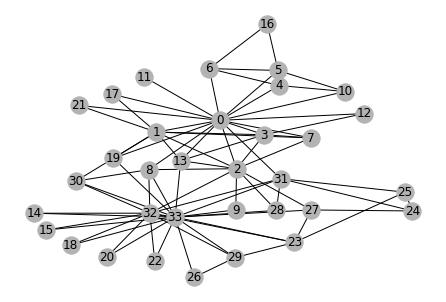

In [4]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Step 2: Assign features to nodes or edges
--------------------------------------------
Graph neural networks associate features with nodes and edges for training.
For our classification example, since there is no input feature, we assign each node
with a learnable embedding vector.



In [5]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

Print out the node features to verify:



In [6]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 0.8045,  1.1713,  1.7937,  0.8552, -0.3405], grad_fn=<SelectBackward>)
tensor([[-0.6798,  0.3971,  2.1982,  1.5535,  2.5094],
        [-2.2012, -0.7735, -0.8608, -2.6219,  1.7660]],
       grad_fn=<IndexBackward>)


Step 3: Define a Graph Convolutional Network (GCN)
--------------------------------------------------
To perform node classification, use the Graph Convolutional Network
(GCN) developed by `Kipf and Welling <https://arxiv.org/abs/1609.02907>`_. Here
is the simplest definition of a GCN framework. We recommend that you 
read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

The above definition of GCN fits into a **message-passing** paradigm: Each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.

![mailbox](https://data.dgl.ai/tutorial/1_first/mailbox.png)

In DGL, we provide implementations of popular Graph Neural Network layers under
the `dgl.<backend>.nn` subpackage. The :class:`~dgl.nn.pytorch.GraphConv` module
implements one Graph Convolutional layer.



In [7]:
from dgl.nn.pytorch import GraphConv

Define a deeper GCN model that contains two GCN layers:



In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)
net

GCN(
  (conv1): GraphConv(in=5, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=2, normalization=both, activation=None)
)

Step 4: Data preparation and initialization
-------------------------------------------

We use learnable embeddings to initialize the node features. Since this is a
semi-supervised setting, only the instructor (node 0) and the club president
(node 33) are assigned labels. The implementation is available as follow.



In [9]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [10]:
net(G, inputs)

tensor([[-0.3590,  0.1040],
        [-0.1348,  0.0232],
        [-0.4539,  0.0497],
        [-0.4994,  0.0703],
        [-0.0268,  0.1220],
        [ 0.0219,  0.2047],
        [-0.2424,  0.2466],
        [-0.1875,  0.2178],
        [-0.1137,  0.0334],
        [-0.0366,  0.0178],
        [-0.3320,  0.1704],
        [-0.1693,  0.0684],
        [-0.0803,  0.1284],
        [-0.1725,  0.2081],
        [-0.0583,  0.0107],
        [-0.0583,  0.0107],
        [-0.0976,  0.2656],
        [-0.2755,  0.2311],
        [-0.0583,  0.0107],
        [-0.2312,  0.2058],
        [-0.0583,  0.0107],
        [-0.2755,  0.2311],
        [-0.0583,  0.0107],
        [-0.0767, -0.0238],
        [ 0.0913, -0.0776],
        [ 0.0181,  0.0420],
        [-0.1188,  0.0523],
        [-0.0551,  0.0597],
        [ 0.0220,  0.0021],
        [-0.0365, -0.0123],
        [-0.2047,  0.1176],
        [-0.3042,  0.0282],
        [-0.1786, -0.0011],
        [-0.3493, -0.0811]], grad_fn=<AddBackward0>)

Step 5: Train then visualize
----------------------------
The training loop is exactly the same as other PyTorch models.
We (1) create an optimizer, (2) feed the inputs to the model,
(3) calculate the loss and (4) use autograd to optimize the model.



In [ ]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

This is a rather toy example, so it does not even have a validation or test
set. Instead, Since the model produces an output feature of size 2 for each node, we can
visualize by plotting the output feature in a 2D space.
The following code animates the training process from initial guess
(where the nodes are not classified correctly at all) to the end
(where the nodes are linearly separable).



In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()

![](https://data.dgl.ai/tutorial/1_first/karate0.png)

   :height: 300px
   :width: 400px
   :align: center



The following animation shows how the model correctly predicts the community
after a series of training epochs.



In [ ]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

![](https://data.dgl.ai/tutorial/1_first/karate.gif)

   :height: 300px
   :width: 400px
   :align: center



Next steps
----------

In the :doc:`next tutorial <2_basics>`, we will go through some more basics
of DGL, such as reading and writing node/edge features.

